# Vision | Domain-Adversarial Training of Neural Networks

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of the paper - [*Unsupervised Domain Adaptation by Backpropagation*](https://arxiv.org/pdf/1409.7495.pdf) by *[Yaroslav Ganin](http://yaroslav.ganin.net/#) et. al.* using PyTorch.

First we'll train the a model on source dataset => MNIST. Then we'll compare it's performance on the target => MNISTM. Then we'll train another model using domain adaptation and test it again on MNISTM. 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../../data/computer_vision/domain_adaptation/Mnist2MnistM/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../../../data/computer_vision/domain_adaptation/Mnist2MnistM/


In [5]:
os.listdir(root_dir)

['mnistM', 'mnist']

## Load MNIST and MNIST-M Data

In [6]:
mnist_dir = root_dir + "mnist/"
mnist_m_dir = root_dir + "mnistM/"

### Preprocess Images

The MNIST-M images are 32x32 while the MNIST images are 28x28. We will resize all images to 28x28 and convert them to tensor. We will also Normalize our images. 

In [7]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "test": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

### Create Train and Test Datasets

In [8]:
# mnist
mnist_dataset_train = datasets.ImageFolder(root = mnist_dir + "train",
                                           transform = image_transforms["train"]
                                          )

mnist_dataset_test = datasets.ImageFolder(root = mnist_dir + "test",
                                           transform = image_transforms["test"]
                                          )


# mnistM
mnist_m_dataset_train_val = datasets.ImageFolder(root = mnist_m_dir + "train",
                                             transform = image_transforms["train"]
                                            )

mnist_m_dataset_test = datasets.ImageFolder(root = mnist_m_dir + "test",
                                            transform = image_transforms["test"]
                                           )

### Create [Train+Validation] Data from Train Set

We will create a validation out of MNIST-M only. So, DANN will train data using both MNIST and MNIST-M and then we'll use DANN to evaluate our validation data which will consist of only MNIST-M.

In [9]:
mnist_m_targets = mnist_m_dataset_train_val.targets

mnist_m_train_idx, mnist_m_val_idx = train_test_split(np.arange(len(mnist_m_targets)), test_size = 0.2, shuffle=True, stratify=mnist_m_targets)

In [10]:
mnist_m_train_sampler = torch.utils.data.SubsetRandomSampler(mnist_m_train_idx)
mnist_m_val_sampler = torch.utils.data.SubsetRandomSampler(mnist_m_val_idx)

### Create Dataloader

In [11]:
BATCH_SIZE = 32

# mnist
mnist_loader_train = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_loader_test = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=1, shuffle=False)

# mnistM
mnist_m_loader_train = torch.utils.data.DataLoader(mnist_m_dataset_train_val, batch_size=BATCH_SIZE, sampler=mnist_m_train_sampler)
mnist_m_loader_val = torch.utils.data.DataLoader(mnist_m_dataset_train_val, batch_size=1, sampler=mnist_m_val_sampler)
mnist_m_loader_test = torch.utils.data.DataLoader(mnist_m_dataset_test, batch_size=1, shuffle=False)

### Explore Data

#### Create ID <=> Class Mapping

In [12]:
mnist_dataset_train.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [13]:
idx2class = {v: k for k, v in mnist_dataset_train.class_to_idx.items()}
idx2class

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

#### Observe Class Distribution

In [14]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

In [15]:
print("MNIST Train", get_class_distribution(mnist_dataset_train))
print("MNIST Test", get_class_distribution(mnist_dataset_test))

print("MNIST-M Train", get_class_distribution(mnist_m_dataset_train_val))
print("MNIST-M Test", get_class_distribution(mnist_m_dataset_test))

MNIST Train {'0': 5923, '1': 6742, '2': 5958, '3': 6131, '4': 5842, '5': 5421, '6': 5918, '7': 6265, '8': 5851, '9': 5949}
MNIST Test {'0': 980, '1': 1135, '2': 1032, '3': 1010, '4': 982, '5': 892, '6': 958, '7': 1028, '8': 974, '9': 1009}
MNIST-M Train {'0': 5825, '1': 6640, '2': 5853, '3': 6028, '4': 5746, '5': 5331, '6': 5812, '7': 6158, '8': 5757, '9': 5851}
MNIST-M Test {'0': 878, '1': 1016, '2': 933, '3': 908, '4': 890, '5': 807, '6': 856, '7': 914, '8': 880, '9': 919}


Text(0.5, 1.0, '[Target]MNIST-M Distribution in Test Set')

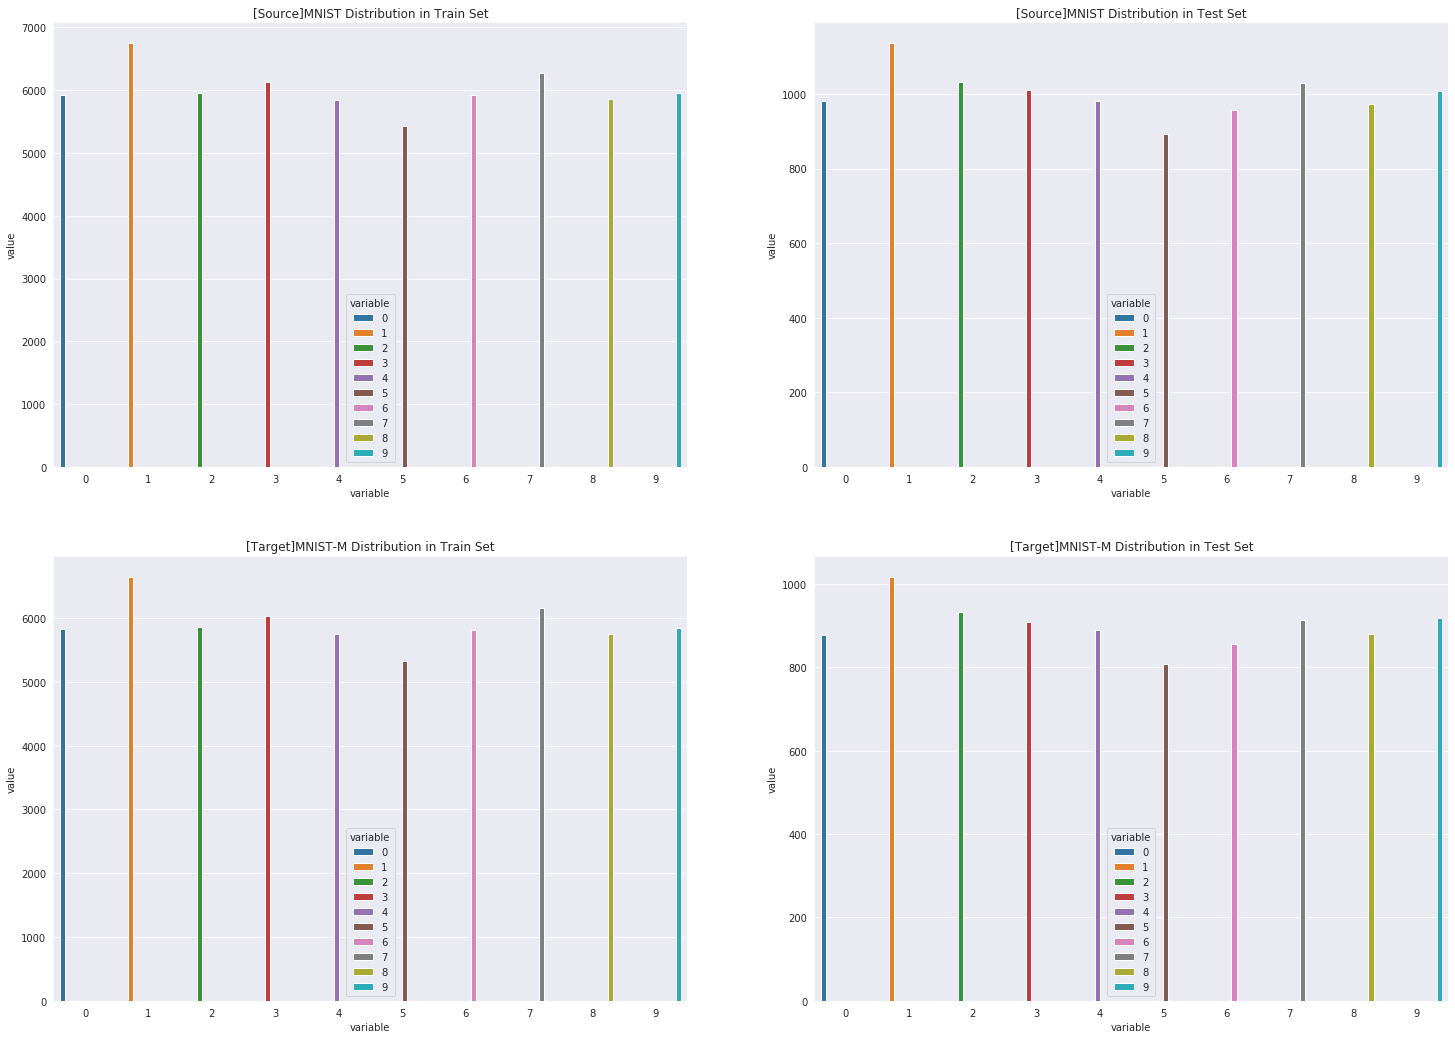

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,18))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_dataset_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0, 0]).set_title('[Source]MNIST Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_dataset_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0, 1]).set_title('[Source]MNIST Distribution in Test Set')

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_m_dataset_train_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1, 0]).set_title('[Target]MNIST-M Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_m_dataset_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1, 1]).set_title('[Target]MNIST-M Distribution in Test Set')

#### MNIST

In [17]:
single_batch = next(iter(mnist_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([32, 3, 28, 28])
Output labels:  torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


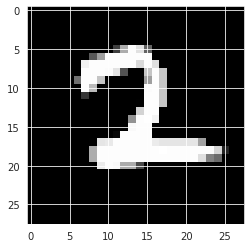

In [18]:
plt.imshow(images[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


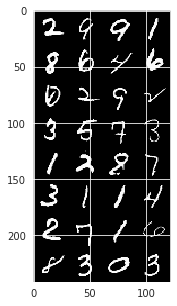

In [19]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

#### MNIST-M

In [20]:
single_batch = next(iter(mnist_m_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([32, 3, 28, 28])
Output labels:  torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


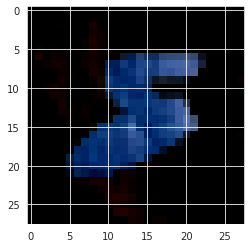

In [21]:
plt.imshow(images[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


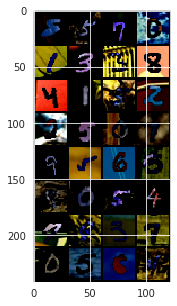

In [22]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## TRAIN on MNIST [Source]

### Model Definition

In [23]:
class ModelMnistSource(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelMnistSource, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )
        
        self.fc = nn.Linear(32*28*28, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### Initialize Model

In [24]:
model_mnist = ModelMnistSource()
print(f"We're using {device}.\n")
model_mnist.to(device)
print(model_mnist)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

We're using cuda.

ModelMnistSource(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)


In [25]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

### Train Loop

In [26]:
EPOCHS = 3

print("Training has started.\n")
for e in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model_mnist.train()
    for X_train_batch, y_train_batch in mnist_loader_train:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model_mnist(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(mnist_loader_train):.5f} | Train Acc: {train_epoch_acc/len(mnist_loader_train):.3f}')

Training has started.



Epoch 001: | Train Loss: 0.24232 | Train Acc: 99.627
Epoch 002: | Train Loss: 0.07129 | Train Acc: 100.000
Epoch 003: | Train Loss: 0.05767 | Train Acc: 100.000



## Test on MNIST [Source]

In [27]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [28]:
print("Trained on MNIST | Tested on MNIST. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST. 


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Test on MNIST-M [Target]

Now, let's test our model on the target dataset, ie. MNIST-M.

To do that, we need to load the data first.

In [29]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [30]:
print("Trained on MNIST | Tested on MNIST-M. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST-M. 


              precision    recall  f1-score   support

           0       0.93      0.38      0.54       878
           1       0.95      0.35      0.51      1016
           2       0.51      0.54      0.52       933
           3       0.65      0.46      0.54       908
           4       0.89      0.30      0.45       890
           5       0.25      0.83      0.38       807
           6       0.70      0.49      0.58       856
           7       0.88      0.33      0.48       914
           8       0.51      0.54      0.52       880
           9       0.35      0.66      0.46       919

    accuracy                           0.48      9001
   macro avg       0.66      0.49      0.50      9001
weighted avg       0.67      0.48      0.50      9001



**As we see from the results above, our model trained on MNIST performs horribly for MNIST-M.**

> Let's see some of that unsupervised domain adaption now.

## Train DANN Model [using MNIST and MNIST-M]

In a DANN, we use both MNIST and MNIST-M ie. source and target to train our model.

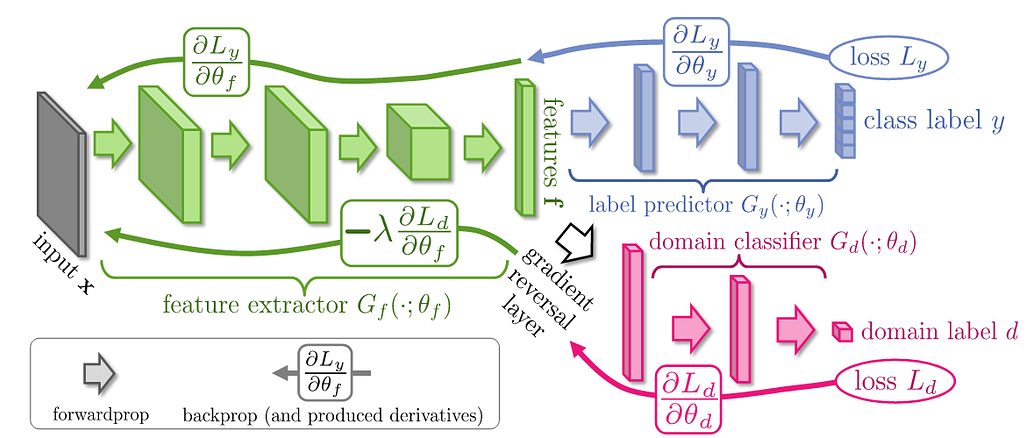

### Gradient Reverse Layer

Before we define the model architecture, we need to implement the **Gradient Reverse Layer**. Check out => [PyTorch: Defining New autograd Functions](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)

In [31]:
class GRL(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input_val, alpha):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. 
        """
        
        ctx.alpha = alpha
        
        # No operation during the forward pass.
        return input_val

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        
        # Multiply the the gradient output by -1.
        output_val = -ctx.alpha * grad_output
        
        return output_val, None

Before we proceed further, let's see the GRL in action. We'll use the same input tensors and compare the effect of our `GRL`.

#### Autograd without GRL

In [32]:
x1 = torch.tensor(1., requires_grad = True)
x2 = torch.tensor(2., requires_grad = True)
x3 = torch.tensor(3., requires_grad = True)
x4 = torch.tensor(4., requires_grad = True)

z1 = x1 * x2 
z2 = x3 * x4
f = z1 + z2

print("f: ", f)

f.backward(retain_graph=True)

print(f"Gradient of x1 = {x1.grad}")
print(f"Gradient of x2 = {x2.grad}")
print(f"Gradient of x3 = {x3.grad}")
print(f"Gradient of x4 = {x4.grad}")

f:  tensor(14., grad_fn=<AddBackward0>)
Gradient of x1 = 2.0
Gradient of x2 = 1.0
Gradient of x3 = 4.0
Gradient of x4 = 3.0


#### Autograd with GRL

In [33]:
x5 = torch.tensor(1., requires_grad = True)
x6 = torch.tensor(2., requires_grad = True)
x7 = torch.tensor(3., requires_grad = True)
x8 = torch.tensor(4., requires_grad = True)

z3 = x5 * x6 
z4 = x7 * x8
g = z3 + z4

g = GRL.apply(g, 1)

print("g: ", g)

g.backward(retain_graph=True)

print(f"Gradient of x5 = {x5.grad}")
print(f"Gradient of x6 = {x6.grad}")
print(f"Gradient of x7 = {x7.grad}")
print(f"Gradient of x8 = {x8.grad}")

g:  tensor(14., grad_fn=<GRLBackward>)
Gradient of x5 = -2.0
Gradient of x6 = -1.0
Gradient of x7 = -4.0
Gradient of x8 = -3.0


As we can see, all the gradients have been multiplied `-1` in the second case.

Let's move on to defining our model.

### Model Definition

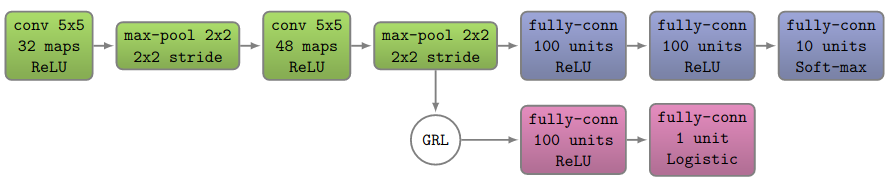

In [34]:
class ModelDANN(nn.Module):
    def __init__(self):
        super(ModelDANN, self).__init__()
                
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.BatchNorm2d(48),
                        
            nn.Flatten(),
            nn.ReLU()
        )
        
        self.class_predictor = nn.Sequential(
            nn.Linear(49 * 48, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
        self.domain_predictor = nn.Sequential(
            nn.Linear(49 * 48, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        
        
    def forward(self, input_image, adaptation_factor=1):
        image_features = self.feature_extractor(input_image)
        
        image_features_grl = GRL.apply(image_features, adaptation_factor)
        
        pred_class_labels = self.class_predictor(image_features)
        pred_domain_labels = self.domain_predictor(image_features_grl)
        
        return pred_class_labels, pred_domain_labels

In [35]:
model_dann = ModelDANN()

model_dann.to(device)

print(model_dann)

criterion_for_class = nn.CrossEntropyLoss()
criterion_for_domain = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_dann.parameters(), lr=0.001)

ModelDANN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Flatten()
    (8): ReLU()
  )
  (class_predictor): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
  (domain_predictor): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


### Model Output Example

In [36]:
x_source_example, y_source_example = next(iter(mnist_loader_train))
x_target_example, y_target_example = next(iter(mnist_m_loader_train))

In [37]:
print("Source input shapes: ", "\n\tX - ", x_source_example.shape, "\n\ty - ",y_source_example.shape)
print("Target input shapes: ", "\n\tX - ", x_target_example.shape, "\n\ty - ",y_target_example.shape)

Source input shapes:  
	X -  torch.Size([32, 3, 28, 28]) 
	y -  torch.Size([32])
Target input shapes:  
	X -  torch.Size([32, 3, 28, 28]) 
	y -  torch.Size([32])


In [38]:
class_example, domain_example = model_dann(x_source_example.to(device), 1.0)
print("Shape of class predictor: ", class_example.shape)
print("Shape of domain predictor: ", domain_example.shape)

Shape of class predictor:  torch.Size([32, 10])
Shape of domain predictor:  torch.Size([32, 2])


### Training Loop

#### The Problem of Number of Batches

We need to do one last thing before we start training. The two datasets (source and target) might have different sizes and as a result, different number of batches. We need to obtain the minimum of the two _number of batches_ between the source and target dataloaders.

In [39]:
MAX_BATCH_NUM = min(len(mnist_loader_train), len(mnist_m_loader_train)) - 1
MAX_BATCH_NUM

1474

In [40]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

Since, everything is working as expected, let's proceed to writing the training loop.

In [41]:
EPOCHS = 25

model_dann.train()

for e in tqdm(range(1, EPOCHS+1)):
    train_dataloader_source = iter(mnist_loader_train)
    train_dataloader_target = iter(mnist_m_loader_train)
    val_dataloader_target = iter(mnist_m_loader_val)
    
    
    # TRAINING
    model_dann.train()
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    for b in range(MAX_BATCH_NUM):
        
        p = np.float(b + e * MAX_BATCH_NUM) / np.float(EPOCHS * MAX_BATCH_NUM)
        lambda_grl = 2. / (1. + np.exp(-10 * p)) - 1
        
        
        x_batch_source, y_batch_source = next(train_dataloader_source)
        x_batch_target, y_batch_target = next(train_dataloader_target)
        
        x_batch_source, y_batch_source = x_batch_source.to(device), y_batch_source.to(device)
        x_batch_target, y_batch_target = x_batch_target.to(device), y_batch_target.to(device)
        
        
        optimizer.zero_grad()
        
        # source
        y_domain_source = torch.zeros(BATCH_SIZE, dtype=torch.long).to(device)
        y_pred_class_source, y_pred_domain_source = model_dann(x_batch_source, lambda_grl)
        
        loss_class_source = criterion_for_class(y_pred_class_source, y_batch_source)
        loss_domain_source = criterion_for_domain(y_pred_domain_source, y_domain_source)
        
        
        # target
        y_domain_target = torch.ones(BATCH_SIZE, dtype=torch.long).to(device)
        y_pred_class_target, y_pred_domain_target = model_dann(x_batch_target, 1)
        
        loss_domain_target = criterion_for_domain(y_pred_domain_target, y_domain_target)
        
        
        # calculate total-loss and class-accuracy for target
        total_loss = loss_class_source + loss_domain_source + loss_domain_target
        target_class_acc= multi_acc(y_pred_class_target, y_batch_target)
        
        
        total_loss.backward()
        optimizer.step()
        
        train_epoch_loss += total_loss.item()
        train_epoch_acc += target_class_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model_dann.eval()
        val_epoch_acc_target = 0
        val_epoch_loss_target = 0
        
        for x_val_target, y_x_val_target in val_dataloader_target:
            x_val_target, y_x_val_target = x_val_target.to(device), y_x_val_target.to(device)
            y_pred_class_target_val, _ = model_dann(x_val_target)
            
            val_acc = multi_acc(y_pred_class_target_val, y_x_val_target)
            val_loss = criterion_for_class(y_pred_class_target_val, y_x_val_target)
            
            val_epoch_acc_target += val_acc.item()
            val_epoch_loss_target += val_loss.item()
            
    
    loss_stats['train'].append(train_epoch_loss/MAX_BATCH_NUM)
    loss_stats['val'].append(val_epoch_loss_target/len(val_dataloader_target))
    accuracy_stats['train'].append(train_epoch_acc/MAX_BATCH_NUM)
    accuracy_stats['val'].append(val_epoch_acc_target/len(val_dataloader_target))
            
        
    print(f'Epoch {e+0:02}: | Train Loss (Total): {train_epoch_loss/MAX_BATCH_NUM:.5f} | Train Acc (Target Class): {train_epoch_acc/MAX_BATCH_NUM:.2f} | Val Loss(Target Class): {val_epoch_loss_target/len(val_dataloader_target):.2f} | Val Acc(Target Class): {val_epoch_acc_target/len(val_dataloader_target):.2f}')

Epoch 01: | Train Loss (Total): 1.07662 | Train Acc (Target Class): 65.26 | Val Loss(Target Class): 1.23 | Val Acc(Target Class): 60.84
Epoch 02: | Train Loss (Total): 0.93936 | Train Acc (Target Class): 88.47 | Val Loss(Target Class): 1.20 | Val Acc(Target Class): 60.60
Epoch 03: | Train Loss (Total): 1.53837 | Train Acc (Target Class): 74.76 | Val Loss(Target Class): 1.78 | Val Acc(Target Class): 49.64
Epoch 04: | Train Loss (Total): 1.42882 | Train Acc (Target Class): 91.04 | Val Loss(Target Class): 1.58 | Val Acc(Target Class): 56.27
Epoch 05: | Train Loss (Total): 1.72553 | Train Acc (Target Class): 61.94 | Val Loss(Target Class): 3.13 | Val Acc(Target Class): 30.47
Epoch 06: | Train Loss (Total): 1.53695 | Train Acc (Target Class): 70.83 | Val Loss(Target Class): 1.42 | Val Acc(Target Class): 58.15
Epoch 07: | Train Loss (Total): 1.44081 | Train Acc (Target Class): 79.99 | Val Loss(Target Class): 1.51 | Val Acc(Target Class): 61.77
Epoch 08: | Train Loss (Total): 1.40837 | Train 

## Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the `accuracy_stats` and `loss_stats` dictionaries.


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

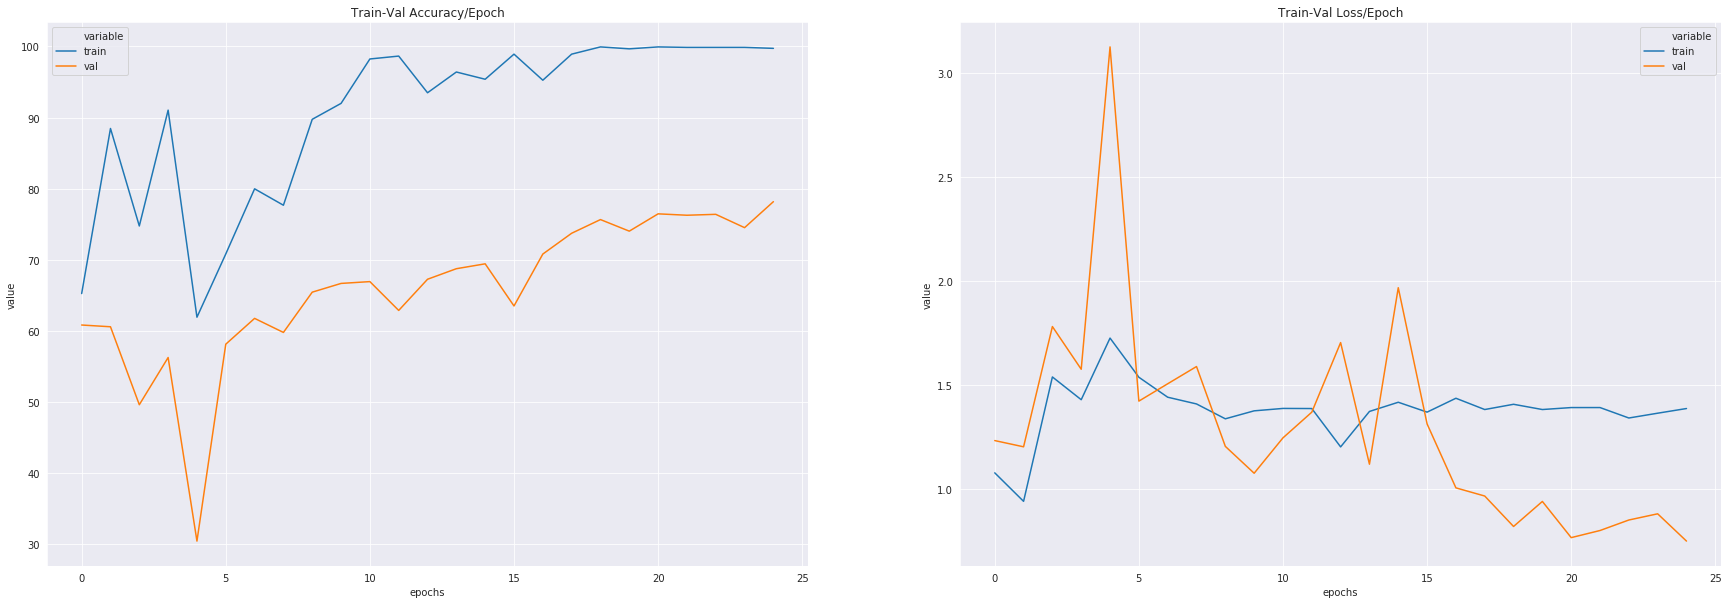

In [42]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



## Test DANN Model on Target [MNIST-M]

In [43]:
y_pred_class_list = []
y_true_class_list = []

with torch.no_grad():
    model_dann.eval()
    epoch_loss = 0
    
    test_dataloader_target = iter(mnist_m_loader_test)
    
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        class_pred, _ = model_dann(x_batch)
        class_pred_logsoftmax = torch.log_softmax(class_pred, dim = 1)
        
        _, class_pred_value = torch.max(class_pred_logsoftmax, dim = 1)
        
        y_true_class_list.append(y_batch.item())
        y_pred_class_list.append(class_pred_value.item())     
    

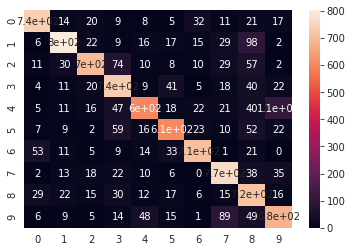

In [44]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_class_list, y_pred_class_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [45]:
print(classification_report(y_true_class_list, y_pred_class_list))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       878
           1       0.86      0.79      0.82      1016
           2       0.85      0.75      0.80       933
           3       0.73      0.81      0.77       908
           4       0.81      0.68      0.74       890
           5       0.79      0.75      0.77       807
           6       0.86      0.83      0.84       856
           7       0.78      0.84      0.81       914
           8       0.63      0.82      0.71       880
           9       0.75      0.74      0.75       919

    accuracy                           0.79      9001
   macro avg       0.79      0.79      0.79      9001
weighted avg       0.79      0.79      0.79      9001



Here we see that DNN model gives an F1 score of 0.75, which is significantly better than the score of 0.51 obtained by the model trained only on MNIST-M using a standard 3 layer CNN.